# Chapter-2-LR

## Method 1: use Tensor and autograd only

In [27]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random


### Generate the dataset

In [28]:
# set the training data
num_inputs = 2 # columns, attributes, features
num_examples = 1000 # rows
true_w = [2,-3.4]
true_b = 4.2

# generate
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

print(features[0],labels[0])


tensor([1.0878, 1.0817]) tensor(2.7049)


##### 可复用代码：作图

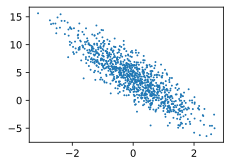

In [29]:
# plot the relationship between features and the label

# 绘制矢量图像：SVG
def use_svg_display():
    display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    # set the size of the figure
    plt.rcParams['figure.figsize'] = figsize
    
set_figsize()
plt.scatter(features[:,1].numpy(), labels.numpy(), 1);


### Load data

In [30]:
# Define a function that returns batch_size samples&labels

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        j = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        yield features.index_select(0,j), labels.index_select(0,j)
        
batch_size = 10
for X,y in data_iter(batch_size, features, labels):
    print(X,y)
    break
    

    

tensor([[ 1.4049, -0.3967],
        [ 1.1230,  2.3420],
        [-0.2067, -0.1125],
        [ 0.4278, -2.7365],
        [-0.2145, -0.6616],
        [ 1.8246,  0.8263],
        [-0.9250,  0.0407],
        [-0.0771,  1.4500],
        [ 1.3435,  0.1136],
        [ 0.5458, -0.7498]]) tensor([ 8.3443, -1.5435,  4.1757, 14.3667,  6.0208,  5.0414,  2.2180, -0.8804,
         6.4809,  7.8277])


### Initialize model parameters, Define model, and Train model

In [31]:
# initialize the paras
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)), dtype=torch.float32) # expectation, standard deriviation, size
b = torch.zeros(1,dtype=torch.float32) # b is initialized to 0

w.requires_grad_(True)
b.requires_grad_(True)

# define the model
# return the output formula
def linear_regression(X, w, b):
    return torch.mm(X,w)+b

# define the loss function
def squared_loss(y_hat, y):
    return (y_hat-y.view(y_hat.size())) ** 2 / 2

# define the optimization function
# perform gradient descent
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size # change the value but no memory address

# train the model
# set the hyperparameters
lr = 0.03
num_epochs = 3
net = linear_regression
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, labels):
        l = loss(net(X,w,b),y).sum() # calculate the total loss of a batch
        l.backward() # do bp
        sgd([w,b], lr, batch_size) # gradient descent for every parameters
        
        # Don't forget to set gradient to zero
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features,w,b),labels)
    print('epoch %d, loss %f' % (epoch+1, train_l.mean().item()))




epoch 1, loss 0.041511
epoch 2, loss 0.000163
epoch 3, loss 0.000051


In [6]:
print(true_b,true_w)
print(b,w)


4.2 [2, -3.4]
tensor([4.1996], requires_grad=True) tensor([[ 1.9995],
        [-3.3999]], requires_grad=True)


## Method 2: Using PyTorch

- 1. torch.nn: nn的核心数据结构是Module，它是一个抽象概念，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承nn.Module，撰写自己的网络/层。一个nn.Module实例应该包含一些层以及返回输出的前向传播（forward）方法.
  - pytorch nn 中都是模型化不是‘层’化
- 2. 用nn.Sequential来更加方便地搭建网络，Sequential是一个有序的容器，网络层将按照在传入Sequential的顺序依次被添加到计算图中。

In [7]:
# set the data
num_inputs = 2
num_examples = 1000
true_w = [2,-3.4]
true_b = 4.2

# generate training samples(features and labels)
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

# load the data
# use data package from PyTorch
import torch.utils.data as Data
batch_size = 10
dataset = Data.TensorDataset(features, labels) # combine features and labels
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True) # batch loader

# define the model
# method 1: self-defined network based on the inheritence of nn.Module
import torch.nn as nn

class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature,1) # nn.Linear(input_size, output_size)
    
    # forward defines forward propagation process:
    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)
print(net) # print the nn structure

# method 2: using nn.Sequential to constrcut network easier
#net = nn.Sequential(
#    nn.Linear(num_inputs,1)
#    )

# another way to use nn.Sequential
#net = nn.Sequential()
#nn.add_module('linear', nn.Linear(num_inputs,1))

# another way to use nn.Sequential
#from collections import OrderedDict
#net = nn.Sequential(OrderedDict([
#    ('linear', nn.Linear(num_inputs,1))
#]))

# check the nn structure
print(net)
#print(net[0])
# use net.parameters() to check all learnable parameters in the model
for param in net.parameters():
    print(param)

    
# initialize the model: torch.nn.init
from torch.nn import init
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)
# if using nn.Sequential
#init.normal_(net[0].weight, mean=0, std=0.01)
#init.constant_(net[0].bias, val=0)

# define the loss function
loss = nn.MSELoss()

# define the optimization funciton
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

# train the model
num_epochs = 3
for epoch in range(1, num_epochs+1): # epoch
    for X,y in data_iter: # batch
        output = net(X) # forward
        l = loss(output, y.view(-1,1)) # loss
        optimizer.zero_grad() 
        l.backward() # backward
        optimizer.step() # optimization
    print('epoch %d, loss: %f' % (epoch, l.item()))

    
    


LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Parameter containing:
tensor([[ 0.4213, -0.0543]], requires_grad=True)
Parameter containing:
tensor([-0.0192], requires_grad=True)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)
epoch 1, loss: 0.000300
epoch 2, loss: 0.000090
epoch 3, loss: 0.000085


In [8]:
# set differnet lr with 1 optimizer:

# method 1
#optimizer =optim.SGD([
#                # 如果对某个参数不指定学习率，就使用最外层的默认学习率
#                {'params': net.subnet1.parameters()}, # lr=0.03
#                {'params': net.subnet2.parameters(), 'lr': 0.01}
#            ], lr=0.03)

# method 2
#for param_group in optimizer.param_groups:
#    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍

# otherwise, we can also set different optimizers. but not good for optimizers like Adam shich uses momentum to optimize

## LR总结

- SGD & MBGD & BGD
  - 对于mini batch SGD，对每个epoch，sample一个minibatch的训练样本，计算平均loss，反向传播更新权重。
  - 对于SGD，对每个epoch，打乱data，再一个一个计算误差，反向传播更新权重。
  - 对于BGD，对每个epoch，对所有data一次进行计算误差再反向传播更新权重。
- PyTorch神经网络（从LR）：
    - 准备数据，将数据处理成batch
    - 定义模型
      - 自己写class：定义init，定义forward等
      - sequential：加入nn模块构成线性模型
    - 初始化参数: torch.nn.init
    - 定义损失函数和优化器: torch.nn.MSELoss, torch.optim
    - 训练模型
      - 对每个epoch，
        - 对每个batch：
          - forward，计算loss，grad清零，对loss backward，optimizer.step()
        - print loss
    - 得出结果
- 一些细节
  - optimizer.step():优化器就是需要根据网络反向传播的梯度信息来更新网络的参数
  - scheduler.step():按照Pytorch的定义是用来 更新优化器的学习率的，一般是按照epoch为单位进行更换，即多少个epoch后更换一次学习率，因而scheduler.step()放在epoch这个大循环下
  - 广播机制：比如在线性模型的‘+b’的时候
  - 矢量运算：比如在线性模型，用所有参数的矩阵来运算而不是一个一个算，提高效率
